# IMPORTING DEPENDENCIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.impute import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")


All modules have been imported


USING CUDA DEVICE TO RUN TENSORFLOW

In [2]:
#DETECT GPUs 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#CHECK WHETHER TENSORFLOW IS USING CUDA"
print(tf.test.is_built_with_cuda())

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4927996720255271800
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1721342363
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11872913899449672844
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
True


In [3]:
# DEFINING PATHS
images_folder = 'C:/Users/rithv/Desktop/General/Diabetic_Retinopathy_Disease_Grading/messidor2/images'
labels_csv = 'C:/Users/rithv/Desktop/General/Diabetic_Retinopathy_Disease_Grading/messidor2/messidor_data.csv'

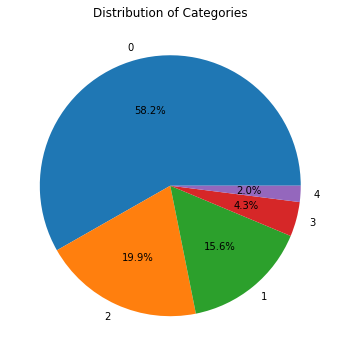

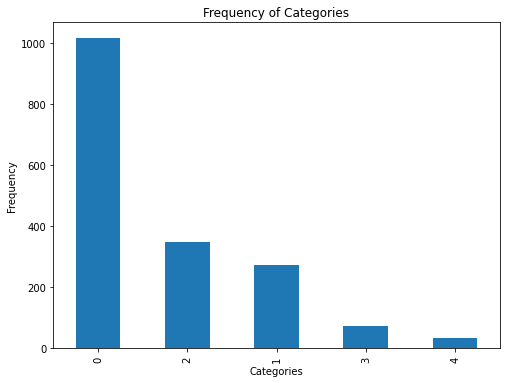

In [4]:
# VIEW THE DISTRIBUTION OF DATASET

df = pd.read_csv(labels_csv)

# Plot a pie chart to show the distribution of categorical variables
plt.figure(figsize=(6, 6))
df['adjudicated_dr_grade'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.ylabel('')


# Plot a bar chart to show the frequency of categorical variables
plt.figure(figsize=(8, 6))
df['adjudicated_dr_grade'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Frequency of Categories')

plt.show()

In [5]:
# VALIDATING THE DISTRIBUTION INTO VARIABLES
df = pd.read_csv(labels_csv)
unique_values = np.unique(df['adjudicated_dr_grade'])
missing_values = np.isnan(df['adjudicated_dr_grade'])

imputer = SimpleImputer(strategy='constant', fill_value=1)  # Replace missing values with 1

imputer.fit(df)

imputed_data = imputer.transform(df)

print(unique_values)
x_label = np.array(df.iloc[:, 0])
y = np.array(df.iloc[:, 1])


print(x_label)
print(y)
print(np.unique(y))
print(df.isnull().sum())


[0 1 2 3 4]
['20051020_43808_0100_PP.png' '20051020_43832_0100_PP.png'
 '20051020_43882_0100_PP.png' ... 'IM004812.jpg' 'IM004831.jpg'
 'IM004832.jpg']
[0 1 1 ... 2 0 0]
[0 1 2 3 4]
image_id                0
adjudicated_dr_grade    0
adjudicated_dme         4
adjudicated_gradable    0
dtype: int64


# DATA PREPROCESSING  

VIEW A SAMPLE IMAGE AFTER PREPROCESSING

In [6]:
import cv2
img = cv2.imread(os.path.join(images_folder, 'IM001941.jpg'))


blurred_image = cv2.GaussianBlur(img, (5, 5), 0)
img_gray = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)
img_norm = cv2.normalize(img_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
img_enhanced = cv2.equalizeHist(img_norm)
cv2.namedWindow('Image Window', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Image Window', img.shape[1], img.shape[0])
cv2.imshow('Image Window', img_enhanced)

print(blurred_image.shape)
'''
# cv2.imshow('Normalized Image', img_norm)
# cv2.imshow('Enhanced Image', img_enhanced)

# img_processed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.namedWindow('Image Window', cv2.WINDOW_NORMAL)
# cv2.resizeWindow('Image Window', img.shape[1], img.shape[0])
# Display the image in a window
# cv2.imshow('Image Window', img_processed)
'''
cv2.waitKey(0)  # Wait until a key is pressed
cv2.destroyAllWindows()  # Close all windows

(1536, 2304, 3)


PREPROCESSING THE TRAINING DATA

In [7]:
from skimage import io, transform

img_width, img_height = 264, 264
channels = 3
file_list = os.listdir(images_folder)
num_samples = len(file_list)
x = np.empty((num_samples, img_width, img_height, channels), dtype=np.uint8)

# Loop over the files in the folder and preprocess the images
for i, file_name in enumerate(file_list):
    # Load the image using the file path
    img_path = os.path.join(images_folder, file_name)
    imgcv = cv2.imread(img_path)

    img_gray = cv2.cvtColor(imgcv, cv2.COLOR_BGR2GRAY)
    img_norm = cv2.normalize(img_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    img_enhanced = cv2.equalizeHist(img_norm)
    #img_enhanced = cv2.resize(img_enhanced, (img_width, img_height))
    #img_resized = cv2.resize(img_enhanced,(img_width, img_height))
    #img_resized = np.reshape(img_resized, (264, 264, 3))
    # Resize the image to the desired shape
    img_resized = transform.resize(img_enhanced, (img_width, img_height, channels), preserve_range=True, anti_aliasing=True)
    x[i,] = np.asarray(img_resized)

print(x.shape)

(1748, 264, 264, 3)


SPLITTING INTRO TRAINING AND TESTING DATA

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=20)


In [9]:

print(len(x))
classes = np.unique(y)
classes_num = len(classes)
print(classes_num)

1748
5


In [10]:
# print(x_train.shape)
# print(y_train.shape)
# x_train = np.transpose(x_train, (1, 2, 3, 0))
# x_test = np.transpose(x_test, (1, 2, 3, 0))
# # y_train = np.transpose(y_train)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)


(1573, 264, 264, 3) (175, 264, 264, 3)
(1573,) (175,)


An optional approach to this problem is by using a categorical classification. Uncomment this cell below and remove the regression part of neural network's head layer and use softmax function" instead 

In [11]:
'''
# x_train = np.transpose(x_train, (0, 2, 1, 3))
# x_test = np.transpose(x_test, (0, 2, 1, 3))
from keras.utils import to_categorical

# Assuming that y_train and y_test are currently of shape (num_samples, 1)
y_train_encoded = to_categorical(y_train, num_classes=5)
y_test_encoded = to_categorical(y_test, num_classes=5)
'''

'\n# x_train = np.transpose(x_train, (0, 2, 1, 3))\n# x_test = np.transpose(x_test, (0, 2, 1, 3))\nfrom keras.utils import to_categorical\n\n# Assuming that y_train and y_test are currently of shape (num_samples, 1)\ny_train_encoded = to_categorical(y_train, num_classes=5)\ny_test_encoded = to_categorical(y_test, num_classes=5)\n'

# MODEL ARCHITECTURE 

In [12]:
# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(264, 264, 3))
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(264, 264, 3))

# Freeze the base model
base_model.trainable = False #should be ideally False 

# Add a regression head to the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
regression_output = Dense(1, activation='linear')(x)

# Scale the regression output to the range 0-4
scaled_output = tf.keras.layers.Lambda(lambda x: x * 4.0)(regression_output)

# Create the new model with the modified output layer
model = Model(inputs=base_model.input, outputs=scaled_output)

# Define the loss function for regression
def regression_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.int64)
    # Scale the true labels to the range 0-4
    scaled_true = y_true * tf.cast((4 // tf.reduce_max(y_true)), tf.int64)
    # Compute the mean squared error loss
    rounded_true = tf.round(tf.cast(scaled_true, tf.float32))
    mse = tf.keras.losses.MeanSquaredError()(rounded_true, y_pred)
    return mse


model.compile(optimizer='adam', loss=regression_loss, metrics=['accuracy','AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 264, 264, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 270, 270, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 132, 132, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
#model.compile(optimizer='adam',loss='mean_squared_error', metrics=['accuracy','AUC']) # use categorical_crossentropy as loss metric for optional approach
history=model.fit(x_train,y_train,epochs=50,batch_size=16,verbose = 1, validation_split=0.1)

Epoch 1/50
89/89 [==============================] - 8s 91ms/step - loss: 0.5487 - accuracy: 0.6219 - auc: 0.9712 - val_loss: 1.8311 - val_accuracy: 0.5253 - val_auc: 0.7322
Epoch 2/50
89/89 [==============================] - 8s 90ms/step - loss: 0.4046 - accuracy: 0.6424 - auc: 0.9718 - val_loss: 1.8305 - val_accuracy: 0.5633 - val_auc: 0.7294
Epoch 3/50
89/89 [==============================] - 8s 90ms/step - loss: 0.3632 - accuracy: 0.6770 - auc: 0.9935 - val_loss: 1.8427 - val_accuracy: 0.5506 - val_auc: 0.7259
Epoch 4/50
89/89 [==============================] - 8s 91ms/step - loss: 0.4703 - accuracy: 0.6488 - auc: 0.9884 - val_loss: 1.9062 - val_accuracy: 0.5823 - val_auc: 0.7350
Epoch 5/50
89/89 [==============================] - 8s 91ms/step - loss: 0.5607 - accuracy: 0.6445 - auc: 0.9806 - val_loss: 1.7185 - val_accuracy: 0.3671 - val_auc: 0.7087
Epoch 6/50
89/89 [==============================] - 8s 91ms/step - loss: 0.4525 - accuracy: 0.6657 - auc: 0.9930 - val_loss: 1.8594 - v

# PERFORMANCE REPORT


In [ ]:
# #y_test=np.argmax(y_test, axis=1)
# pred=np.argmax(model.predict(x_test),axis=-1)
# cm=confusion_matrix(y_test,pred)
# cm_plot=plot_confusion_matrix(cm,classes=['0','1'])

In [ ]:
# print("Performance Report:")
# y_pred6=np.argmax(model.predict(x_test),axis=-1)
# Y_test=to_categorical(y_test,5)
# y_pred_prb6=model.predict(x_test)
# #target=['0','1']
# from sklearn import metrics
# print('Accuracy score is :', metrics.accuracy_score(y_test, y_pred6))
# print('Precision score is :', metrics.precision_score(y_test, y_pred6, average='weighted'))
# print('Recall score is :',metrics.recall_score(y_test,y_pred6, average='weighted'))
# print('F1 Score is :', metrics.f1_score(y_test, y_pred6,average='weighted'))
# print('Cohen Kappa Score:', metrics.cohen_kappa_score(y_test, y_pred6))

In [15]:

label_encoder = LabelEncoder()
y_pred = model.predict(x_test)
y_test = label_encoder.fit_transform(y_test)
y_pred = label_encoder.fit_transform(y_pred)
report = classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4],
                               target_names=['Class'])

print(report)
kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's kappa score:", kappa)

6/6 [==============================] - 2s 133ms/step
              precision    recall  f1-score   support

       Class       0.82      0.47      0.60        99

   micro avg       0.77      0.27      0.40       175
   macro avg       0.16      0.09      0.12       175
weighted avg       0.47      0.27      0.34       175

Cohen's kappa score: 0.10061832490163014


In [16]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
selectivity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
print("Selectivity:", selectivity)
print("Sensitivity:", sensitivity)

Selectivity: 0.9791666666666666
Sensitivity: 0.0
